In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

### Data analysis

In [2]:
data = pd.read_csv('nbaallelo.csv')
display(data)

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,...,40.294830,NYK,Knicks,68,1300.0000,1306.7233,H,L,0.640065,NaN
1,1,194611010TRH,NBA,1,1947,11/1/1946,1,0,NYK,Knicks,...,41.705170,TRH,Huskies,66,1300.0000,1293.2767,A,W,0.359935,NaN
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,...,42.012257,NYK,Knicks,47,1306.7233,1297.0712,H,W,0.631101,NaN
3,2,194611020CHS,NBA,1,1947,11/2/1946,2,0,NYK,Knicks,...,40.692783,CHS,Stags,63,1300.0000,1309.6521,A,L,0.368899,NaN
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,...,38.864048,WSC,Capitols,50,1300.0000,1320.3811,H,L,0.640065,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126309,63155,201506110CLE,NBA,0,2015,6/11/2015,100,1,CLE,Cavaliers,...,60.309792,GSW,Warriors,103,1790.9591,1809.9791,H,L,0.546572,NaN
126310,63156,201506140GSW,NBA,0,2015,6/14/2015,102,1,GSW,Warriors,...,68.013329,CLE,Cavaliers,91,1704.3949,1700.7391,H,W,0.765565,NaN
126311,63156,201506140GSW,NBA,1,2015,6/14/2015,101,1,CLE,Cavaliers,...,60.010067,GSW,Warriors,104,1809.9791,1813.6349,A,L,0.234435,NaN
126312,63157,201506170CLE,NBA,0,2015,6/16/2015,102,1,CLE,Cavaliers,...,59.290245,GSW,Warriors,105,1813.6349,1822.2881,H,L,0.481450,NaN


In [3]:
set(data['game_location'])

{'A', 'H', 'N'}

In [8]:
E1 = np.array(data['elo_i'])
E2 = np.array(data['opp_elo_i'])
P = np.array(data['pts'] - data['opp_pts'])

print(E1.min(), E2.min())
print(E1.max(), E2.max())
print(abs(E1 - E2).max(), abs(E1 - E2).min())

1091.6445 1091.6445
1853.1045 1853.1045
572.1608999999999 0.0


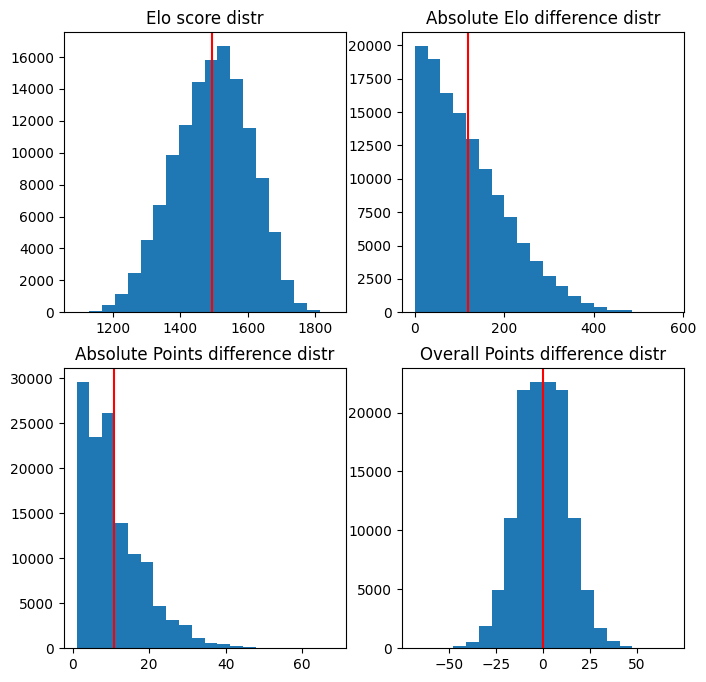

In [10]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.hist(E1, bins=20)
plt.axvline(x = E1.mean(), color = 'r', label = 'Mean')
plt.title('Elo score distr')

plt.subplot(2, 2, 2)
plt.hist(abs(E1 - E2), bins=20)
plt.axvline(x = abs(E1 - E2).mean(), color = 'r', label = 'Mean')
plt.title('Absolute Elo difference distr')

plt.subplot(2, 2, 3)
plt.hist(abs(P), bins=20)
plt.axvline(x = abs(P).mean(), color = 'r', label = 'Mean')
plt.title('Absolute Points difference distr')

plt.subplot(2, 2, 4)
plt.hist(P, bins=20)
plt.axvline(x = P.mean(), color = 'r', label = 'Mean')
plt.title('Overall Points difference distr')

plt.show()

### Helper functions

In [76]:
def plot(E_beg, E_end, E_diff, eps, b, return_aic=False):

  samples = np.array([])
  for e1, e2, e_diff, p in zip(E1, E2, E1 - E2, P):
    if e1 < E_beg or e1 > E_end:
      continue
    if e2 < E_beg or e2 > E_end:
      continue

    if abs(e_diff - E_diff) <= eps:
      samples = np.append(samples, p)

  print(f'No. of samples = {len(samples)}')

  n, aic_scores, bic_scores = find_optimal_components(samples.reshape(-1, 1))

# Plotting best-fit gmm
  gmm = GaussianMixture(n_components=n, random_state=0)
  gmm.fit(samples.reshape(-1, 1))
  x_axis = np.linspace(samples.min(), samples.max())
  log_prob = gmm.score_samples(x_axis.reshape(-1, 1))
  pdf = np.exp(log_prob)
  plt.plot(x_axis, pdf, label='Best-fit GMM with n=1 component')

  means = gmm.means_
  covariances = gmm.covariances_

  print(f'Mean = {means[0]}, Covariance = {covariances[0]}')

# Plotting histogram
  plt.hist(samples, density=True, bins=b)
  plt.xlabel('Points difference')
  plt.ylabel('Probability')
  plt.legend(fontsize='large')
  # plt.axvline(x = 0, color = 'r', label = 'Zero')

  if return_aic:
    return aic_scores, bic_scores


In [35]:
def find_optimal_components(X):
  n_components = range(1, 5)
  models = [GaussianMixture(n, random_state=42).fit(X) for n in n_components]
  aic_scores = [model.aic(X) for model in models]
  bic_scores = [model.bic(X) for model in models]
  best_aic = np.argmin(aic_scores) + 1
  best_bic = np.argmin(bic_scores) + 1

  print("Best number of components based on AIC:", best_aic)
  print("Best number of components based on BIC:", best_bic)

  return best_bic, aic_scores, bic_scores

In [25]:
def plot_diffbins(E_beg, E_end, E_diff, eps):
  plt.figure()

  plt.subplot(2, 2, 1)
  plot(E_beg, E_end, E_diff, eps, 20)

  plt.subplot(2, 2, 2)
  plot(E_beg, E_end, E_diff, eps, 30)

  plt.subplot(2, 2, 3)
  plot(E_beg, E_end, E_diff, eps, 40)

  plt.subplot(2, 2, 4)
  plot(E_beg, E_end, E_diff, eps, 50)

  plt.show()

In [86]:
def sample_plot(E_beg, E_end, E_diff, eps):

  aic_scores, bic_scores = plot(E_beg, E_end, E_diff, eps, 30, return_aic=True)
  plt.show()

  n_components = range(1, 5)
  plt.plot(n_components, aic_scores, label='AIC')
  plt.plot(n_components, bic_scores, label='BIC')

  plt.xlabel('Number of components')
  plt.ylabel('AIC and BIC values')
  plt.xticks(n_components)
  plt.legend(fontsize='large')
  plt.show()

### Experiments with fixed $\Delta E$

#### $\Delta E=100 \pm 5$

No. of samples = 729
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.218107], Covariance = [[144.57108603]]


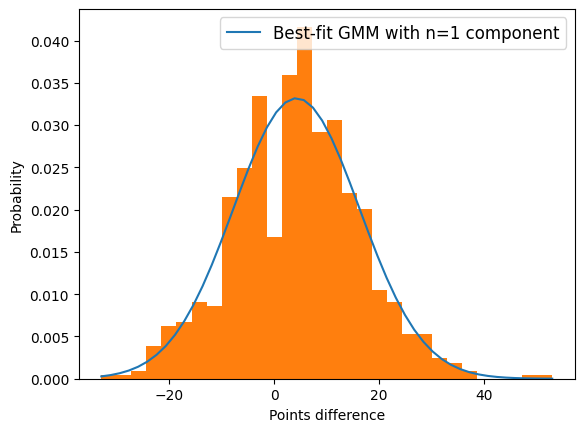

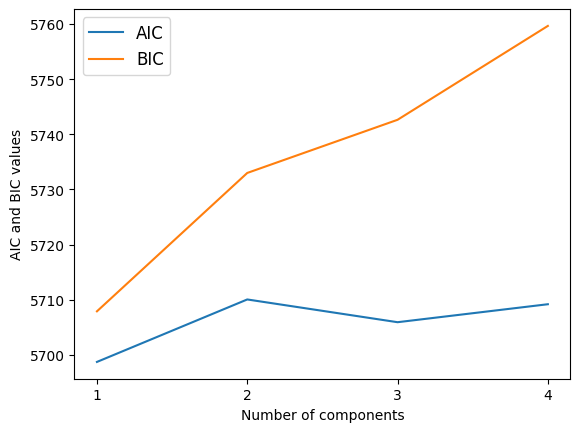

In [87]:
sample_plot(1200, 1500, 100, 5)

No. of samples = 729
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.218107], Covariance = [[144.57108603]]
No. of samples = 729
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.218107], Covariance = [[144.57108603]]
No. of samples = 729
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.218107], Covariance = [[144.57108603]]
No. of samples = 729
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.218107], Covariance = [[144.57108603]]


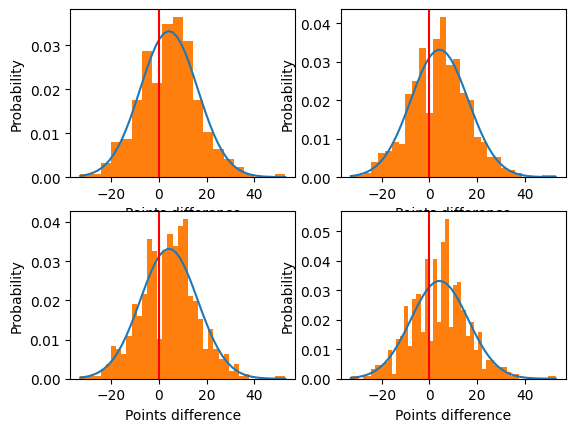

In [26]:
plot_diffbins(1200, 1500, 100, 5)

No. of samples = 687
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.0713246], Covariance = [[154.9599793]]


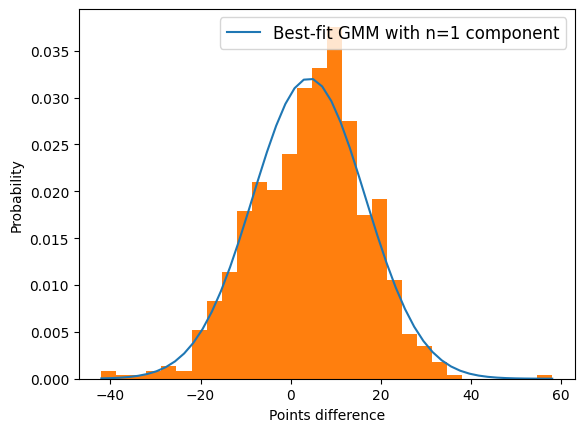

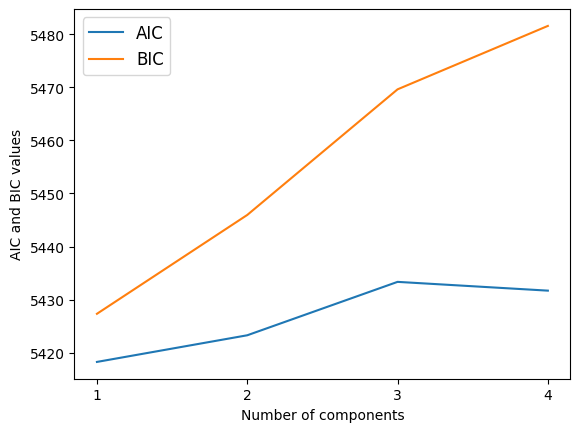

In [88]:
sample_plot(1500, 1800, 100, 5)

No. of samples = 687
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.0713246], Covariance = [[154.9599793]]
No. of samples = 687
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.0713246], Covariance = [[154.9599793]]
No. of samples = 687
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.0713246], Covariance = [[154.9599793]]
No. of samples = 687
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.0713246], Covariance = [[154.9599793]]


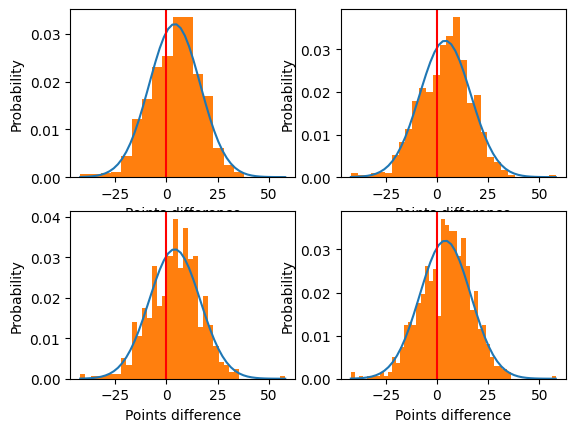

In [ ]:
plot_diffbins(1500, 1800, 100, 5)

No. of samples = 2547
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.64742835], Covariance = [[150.07985599]]


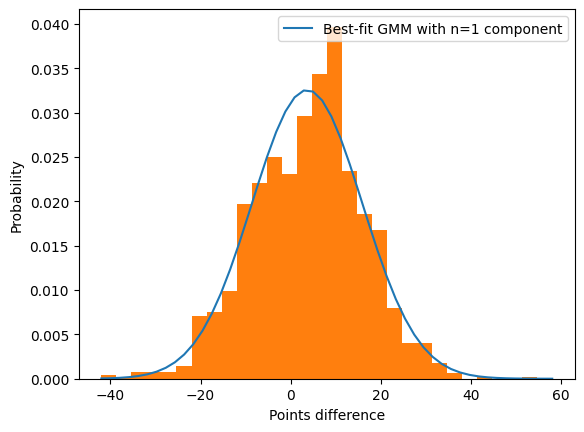

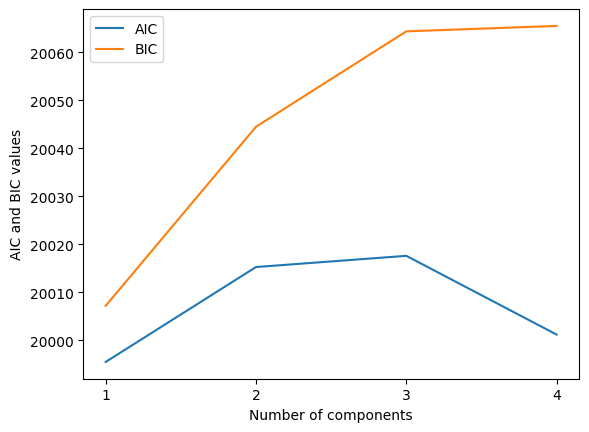

In [55]:
sample_plot(1000, 1900, 100, 5)

No. of samples = 2547
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.64742835], Covariance = [[150.07985599]]
No. of samples = 2547
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.64742835], Covariance = [[150.07985599]]
No. of samples = 2547
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.64742835], Covariance = [[150.07985599]]
No. of samples = 2547
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.64742835], Covariance = [[150.07985599]]


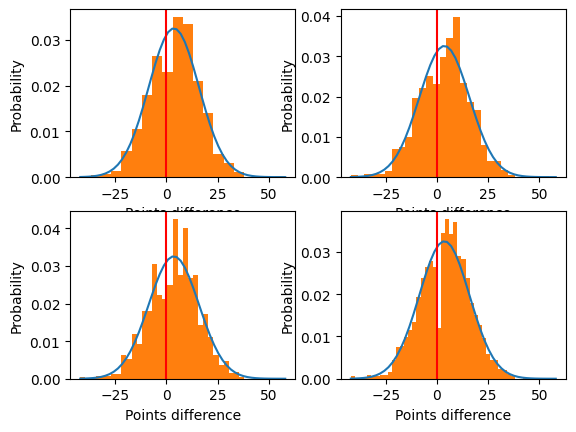

In [ ]:
plot_diffbins(1000, 1900, 100, 5)

No. of samples = 742
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.18328841], Covariance = [[144.74268668]]


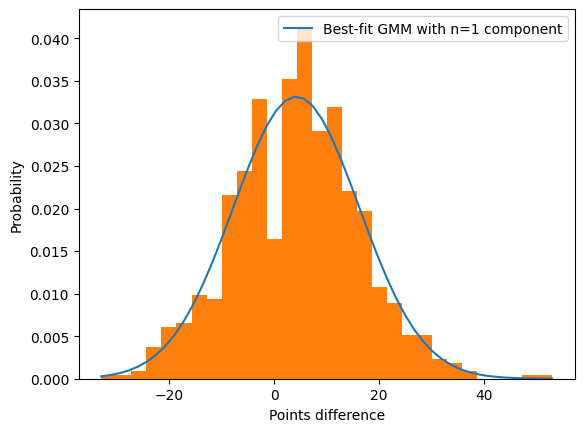

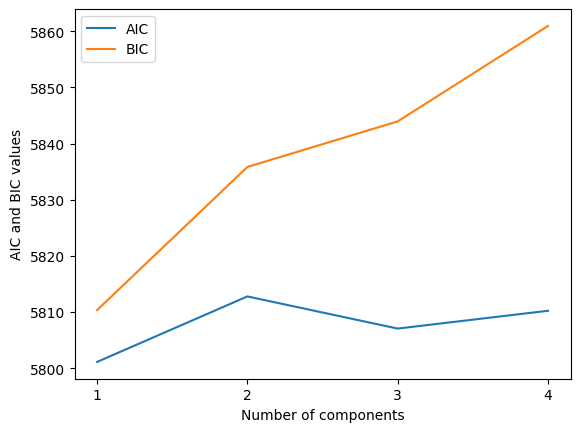

In [56]:
sample_plot(1000, 1500, 100, 5)

No. of samples = 742
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.18328841], Covariance = [[144.74268668]]
No. of samples = 742
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.18328841], Covariance = [[144.74268668]]
No. of samples = 742
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.18328841], Covariance = [[144.74268668]]
No. of samples = 742
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [4.18328841], Covariance = [[144.74268668]]


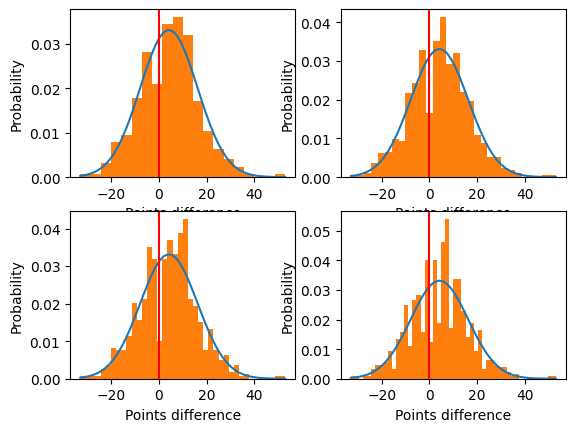

In [ ]:
plot_diffbins(1000, 1500, 100, 5)

#### $\Delta E = 200 \pm 10$

No. of samples = 340
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.33823529], Covariance = [[161.58265671]]


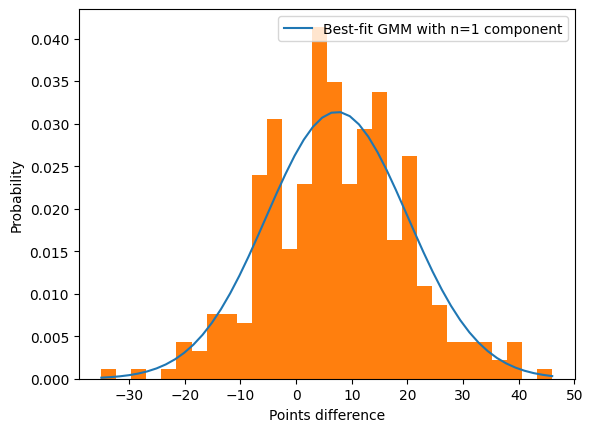

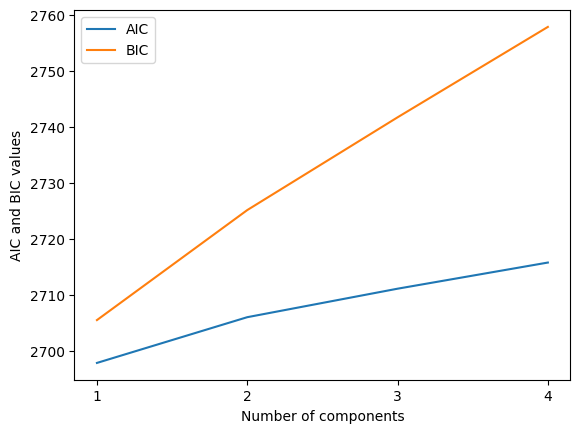

In [57]:
sample_plot(1200, 1500, 200, 10)

No. of samples = 340
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.33823529], Covariance = [[161.58265671]]
No. of samples = 340
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.33823529], Covariance = [[161.58265671]]
No. of samples = 340
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.33823529], Covariance = [[161.58265671]]
No. of samples = 340
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.33823529], Covariance = [[161.58265671]]


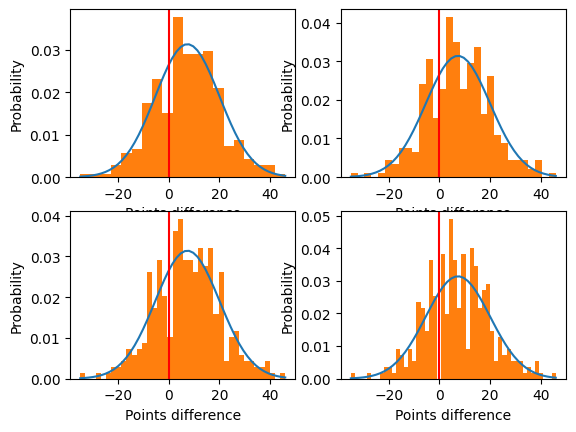

In [ ]:
plot_diffbins(1200, 1500, 200, 10)

No. of samples = 168
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [6.73214286], Covariance = [[141.66039641]]


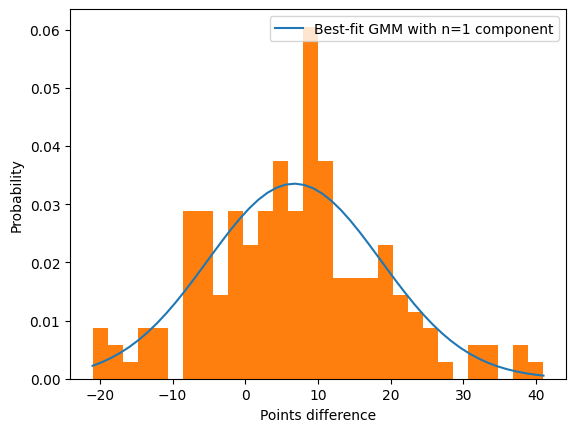

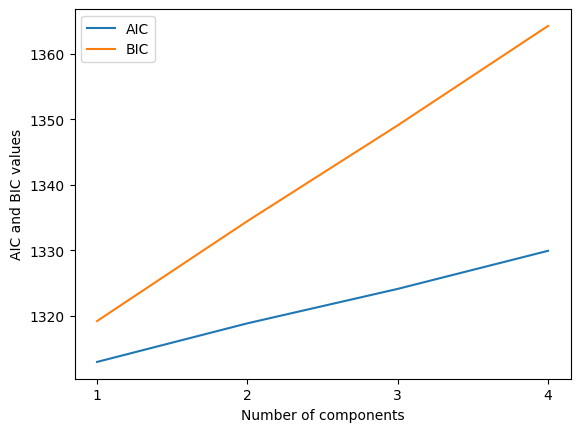

In [58]:
sample_plot(1500, 1800, 200, 10)

No. of samples = 168
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [6.73214286], Covariance = [[141.66039641]]
No. of samples = 168
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [6.73214286], Covariance = [[141.66039641]]
No. of samples = 168
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [6.73214286], Covariance = [[141.66039641]]
No. of samples = 168
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [6.73214286], Covariance = [[141.66039641]]


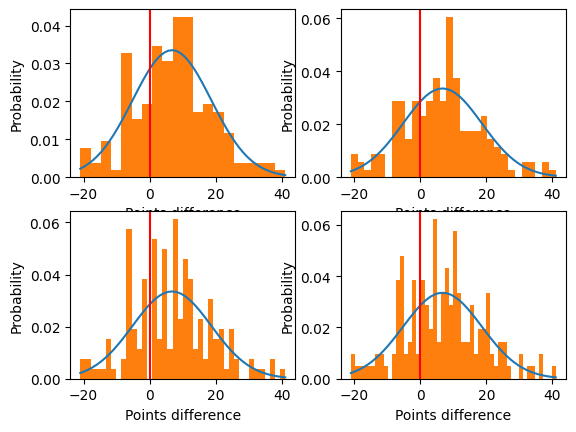

In [ ]:
plot_diffbins(1500, 1800, 200, 10)

No. of samples = 2911
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.15596015], Covariance = [[150.39752559]]


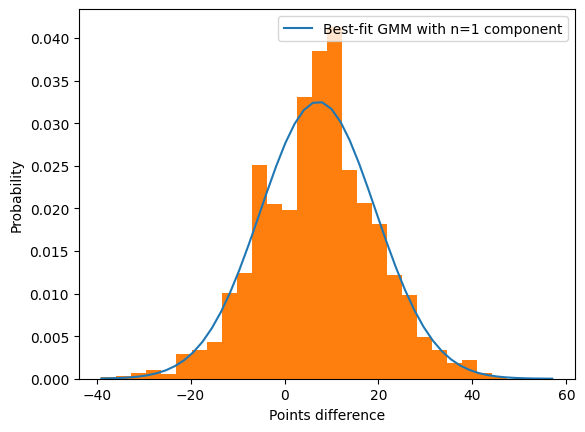

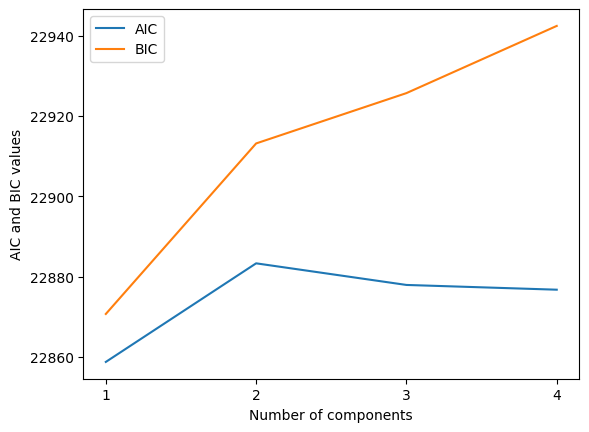

In [59]:
sample_plot(1000, 1900, 200, 10)

No. of samples = 2911
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.15596015], Covariance = [[150.39752559]]
No. of samples = 2911
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.15596015], Covariance = [[150.39752559]]
No. of samples = 2911
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.15596015], Covariance = [[150.39752559]]
No. of samples = 2911
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.15596015], Covariance = [[150.39752559]]


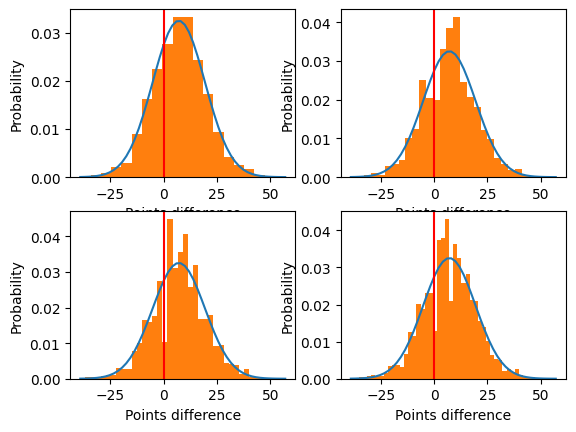

In [ ]:
plot_diffbins(1000, 1900, 200, 10)

No. of samples = 367
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.27792916], Covariance = [[167.14346483]]


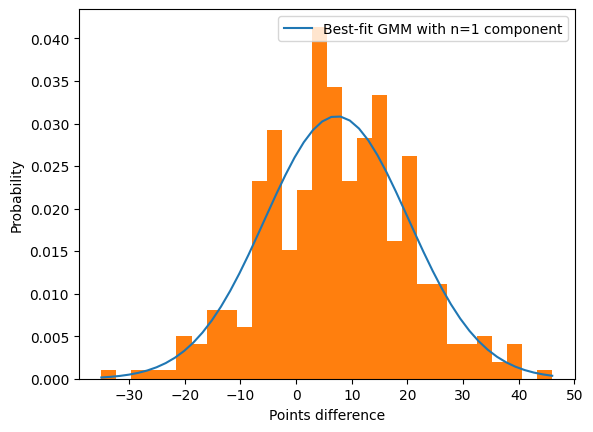

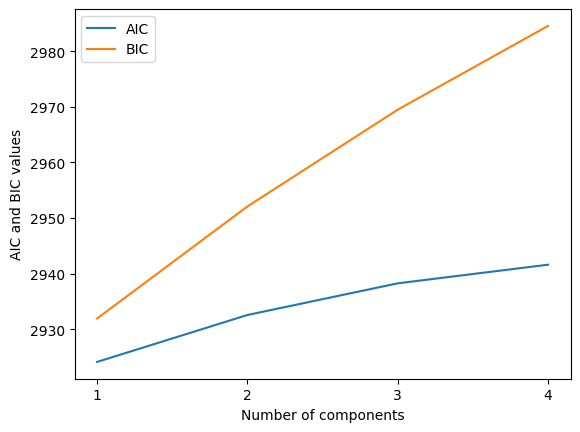

In [60]:
sample_plot(1000, 1500, 200, 10)

No. of samples = 367
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.27792916], Covariance = [[167.14346483]]
No. of samples = 367
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.27792916], Covariance = [[167.14346483]]
No. of samples = 367
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.27792916], Covariance = [[167.14346483]]
No. of samples = 367
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [7.27792916], Covariance = [[167.14346483]]


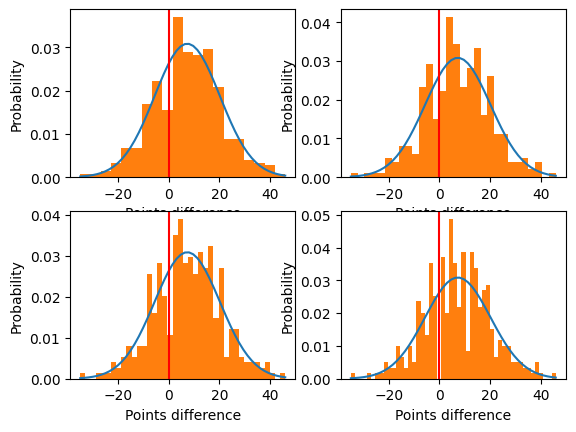

In [ ]:
plot_diffbins(1000, 1500, 200, 10)

#### $\Delta E = 50 \pm 5$

No. of samples = 1124
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.31850534], Covariance = [[151.43414254]]


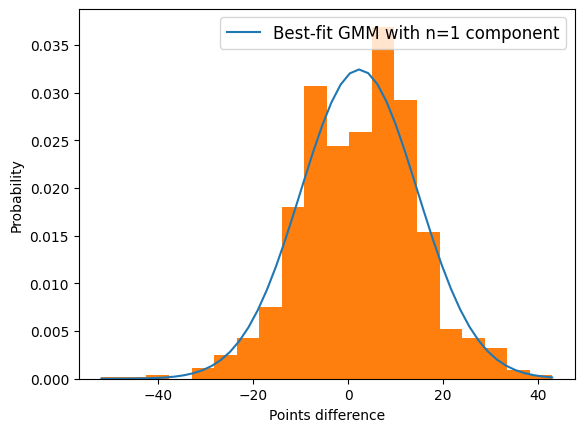

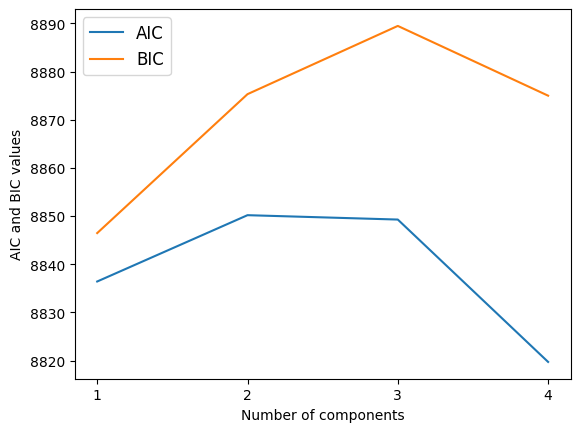

In [84]:
sample_plot(1200, 1500, 50, 5)

No. of samples = 1124
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.31850534], Covariance = [[151.43414254]]
No. of samples = 1124
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.31850534], Covariance = [[151.43414254]]
No. of samples = 1124
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.31850534], Covariance = [[151.43414254]]
No. of samples = 1124
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.31850534], Covariance = [[151.43414254]]


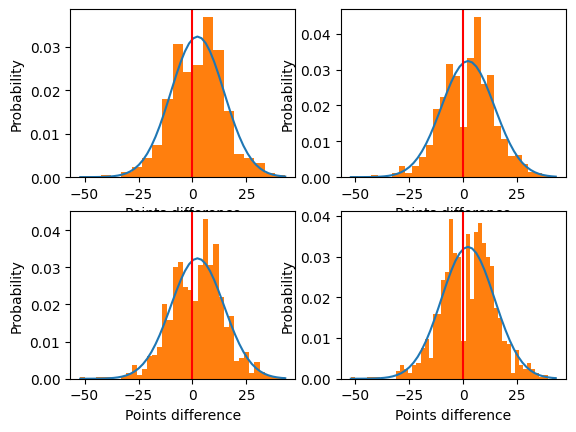

In [ ]:
plot_diffbins(1200, 1500, 50, 5)

No. of samples = 1379
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.14938361], Covariance = [[147.13214529]]


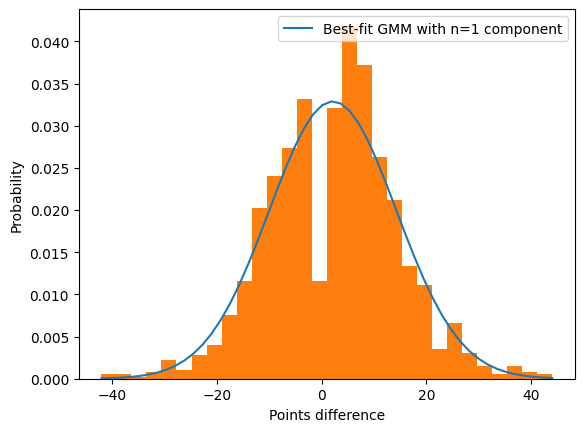

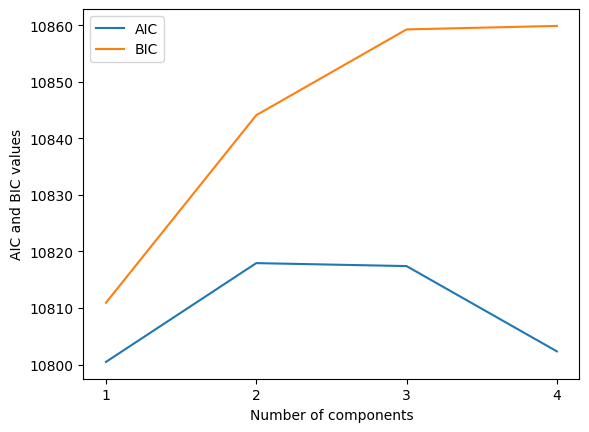

In [62]:
sample_plot(1500, 1800, 50, 5)

No. of samples = 1379
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.14938361], Covariance = [[147.13214529]]
No. of samples = 1379
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.14938361], Covariance = [[147.13214529]]
No. of samples = 1379
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.14938361], Covariance = [[147.13214529]]
No. of samples = 1379
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.14938361], Covariance = [[147.13214529]]


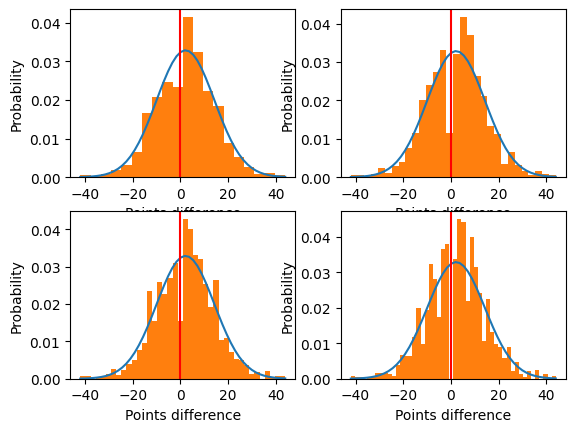

In [ ]:
plot_diffbins(1500, 1800, 50, 5)

No. of samples = 3253
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.14694128], Covariance = [[150.60613751]]


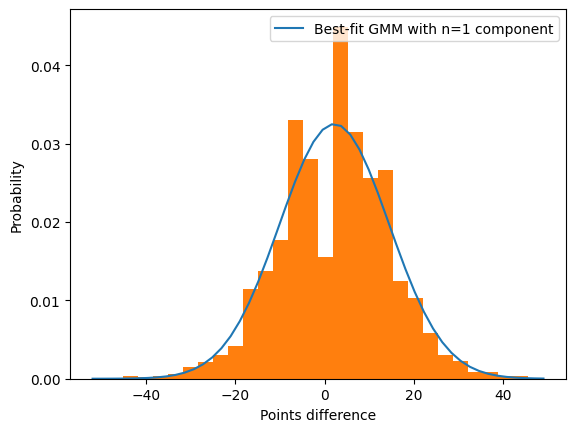

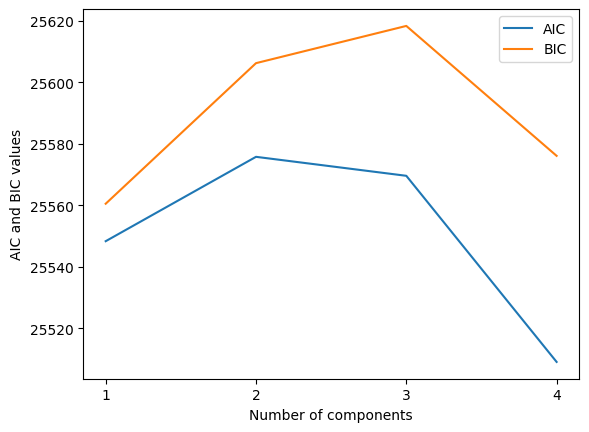

In [63]:
sample_plot(1000, 1900, 50, 5)

No. of samples = 3253
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.14694128], Covariance = [[150.60613751]]
No. of samples = 3253
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.14694128], Covariance = [[150.60613751]]
No. of samples = 3253
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.14694128], Covariance = [[150.60613751]]
No. of samples = 3253
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.14694128], Covariance = [[150.60613751]]


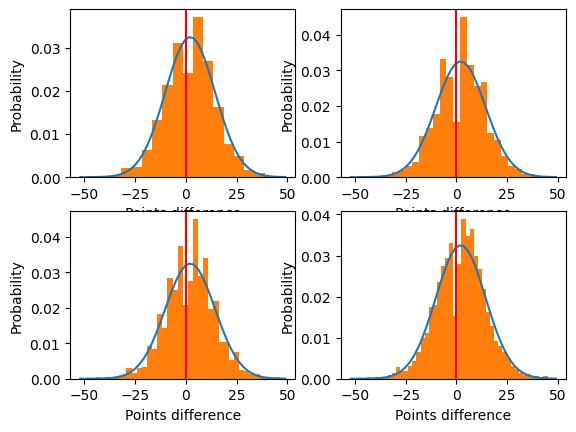

In [ ]:
plot_diffbins(1000, 1900, 50, 5)

No. of samples = 1130
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.29823009], Covariance = [[152.03229875]]


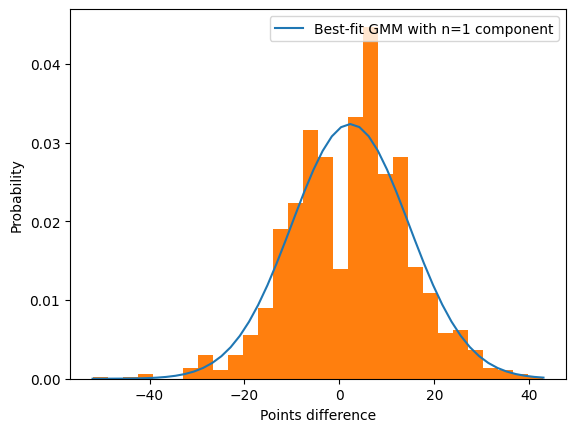

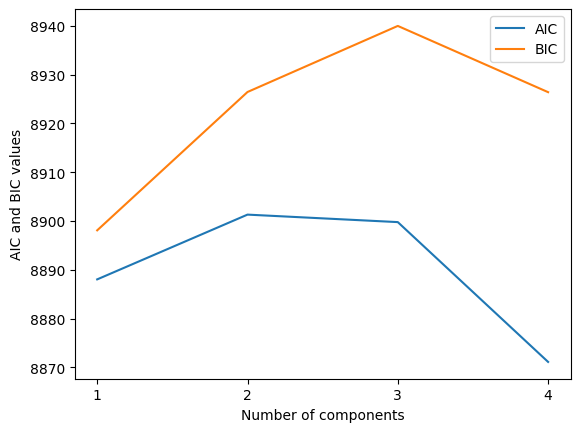

In [64]:
sample_plot(1000, 1500, 50, 5)

No. of samples = 1130
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.29823009], Covariance = [[152.03229875]]
No. of samples = 1130
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.29823009], Covariance = [[152.03229875]]
No. of samples = 1130
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.29823009], Covariance = [[152.03229875]]
No. of samples = 1130
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [2.29823009], Covariance = [[152.03229875]]


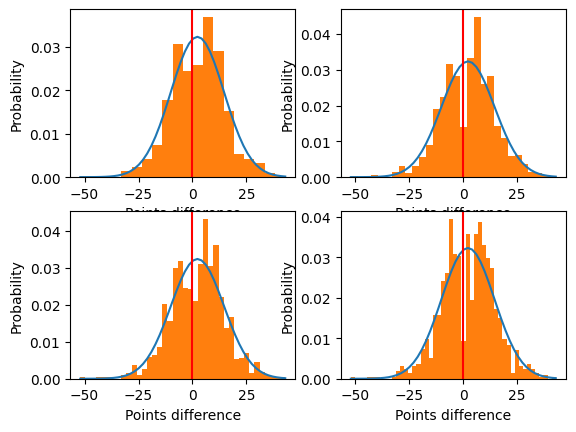

In [ ]:
plot_diffbins(1000, 1500, 50, 5)

##### Trying 100-range for ELo score

No. of samples = 155
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.27741935], Covariance = [[146.84562015]]


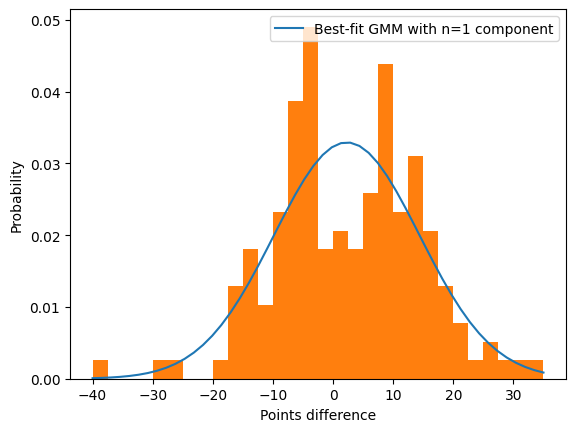

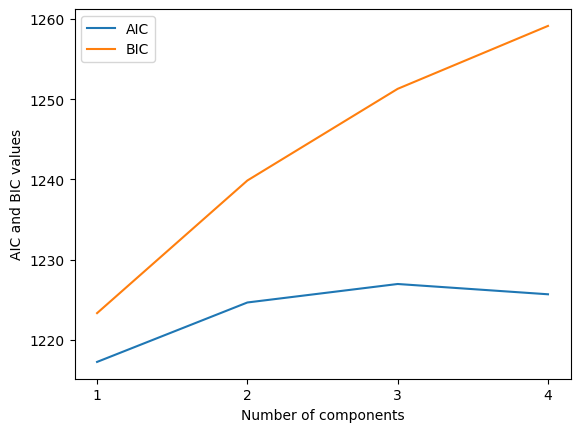

In [65]:
sample_plot(1300, 1400, 50, 5)

No. of samples = 155
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.27741935], Covariance = [[146.84562015]]
No. of samples = 155
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.27741935], Covariance = [[146.84562015]]
No. of samples = 155
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.27741935], Covariance = [[146.84562015]]
No. of samples = 155
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.27741935], Covariance = [[146.84562015]]


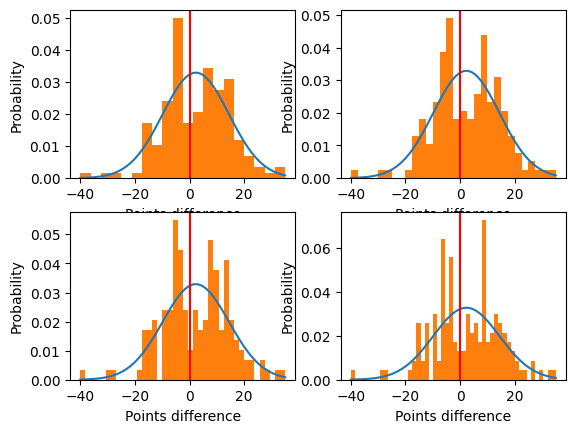

In [ ]:
plot_diffbins(1300, 1400, 50, 5)

No. of samples = 542
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.46678967], Covariance = [[153.86882427]]


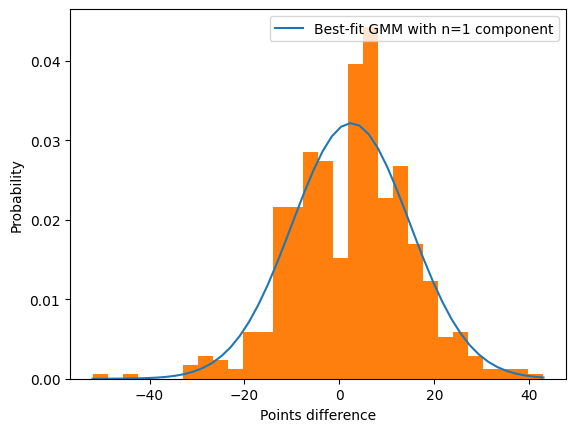

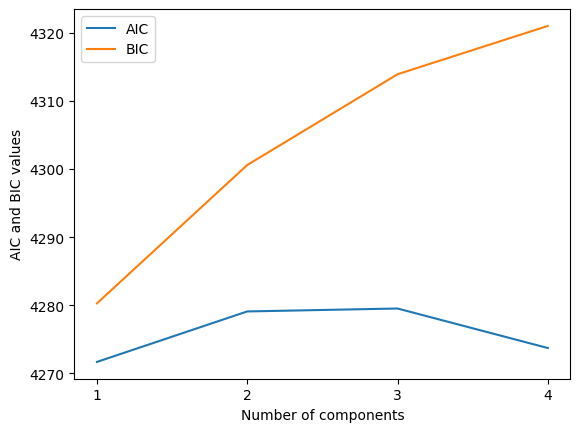

In [66]:
sample_plot(1400, 1500, 50, 5)

No. of samples = 542
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.46678967], Covariance = [[153.86882427]]
No. of samples = 542
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.46678967], Covariance = [[153.86882427]]
No. of samples = 542
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.46678967], Covariance = [[153.86882427]]
No. of samples = 542
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.46678967], Covariance = [[153.86882427]]


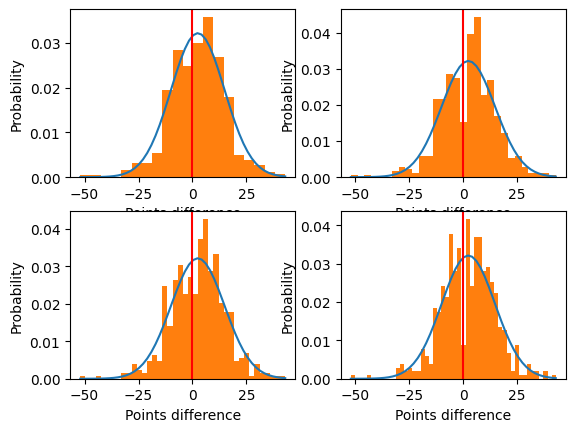

In [ ]:
plot_diffbins(1400, 1500, 50, 5)

No. of samples = 692
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.90606936], Covariance = [[137.46950174]]


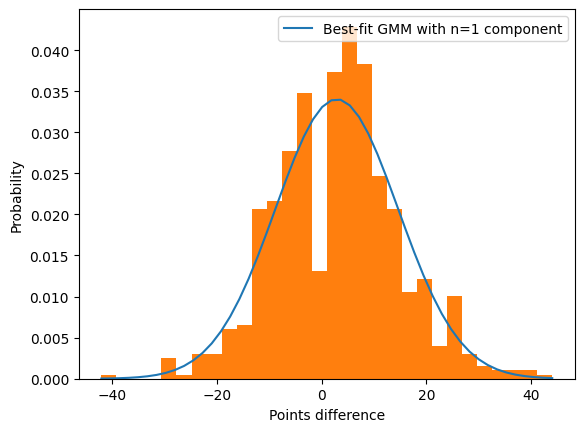

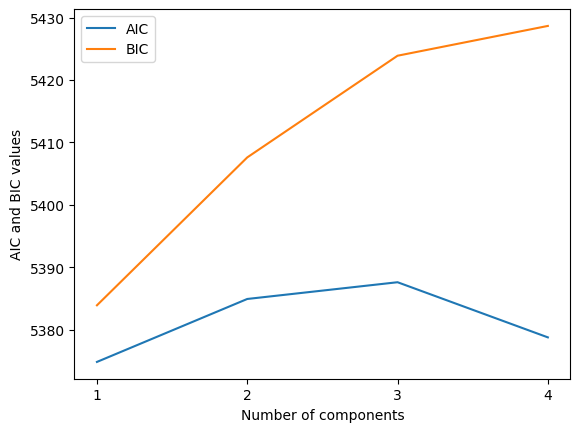

In [67]:
sample_plot(1500, 1600, 50, 5)

No. of samples = 692
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.90606936], Covariance = [[137.46950174]]
No. of samples = 692
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.90606936], Covariance = [[137.46950174]]
No. of samples = 692
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.90606936], Covariance = [[137.46950174]]
No. of samples = 692
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.90606936], Covariance = [[137.46950174]]


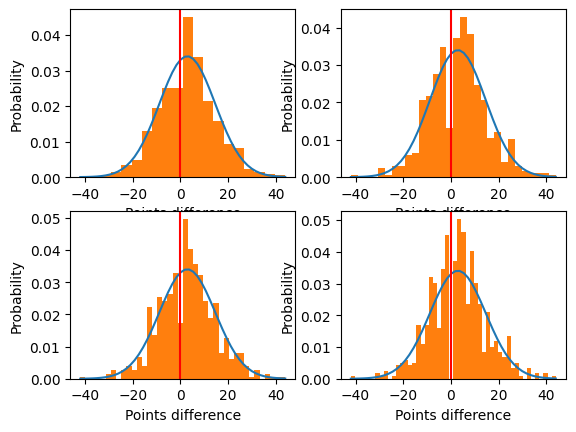

In [ ]:
plot_diffbins(1500, 1600, 50, 5)

No. of samples = 212
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.19339623], Covariance = [[166.19373098]]


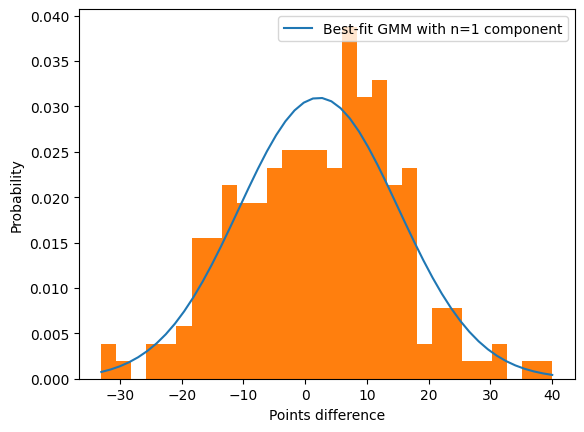

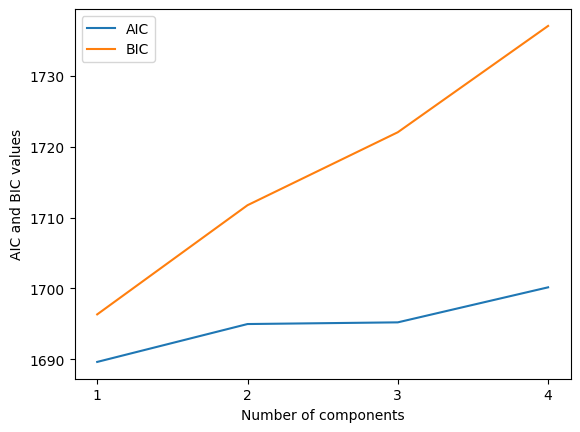

In [68]:
sample_plot(1600, 1700, 50, 5)

No. of samples = 212
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.19339623], Covariance = [[166.19373098]]
No. of samples = 212
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.19339623], Covariance = [[166.19373098]]
No. of samples = 212
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.19339623], Covariance = [[166.19373098]]
No. of samples = 212
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [2.19339623], Covariance = [[166.19373098]]


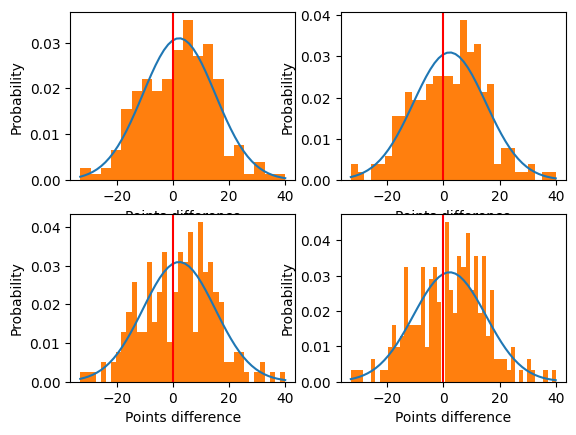

In [ ]:
plot_diffbins(1600, 1700, 50, 5)

#### $\Delta E = 20 \pm 2$

No. of samples = 581
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [0.43373494], Covariance = [[149.87727948]]


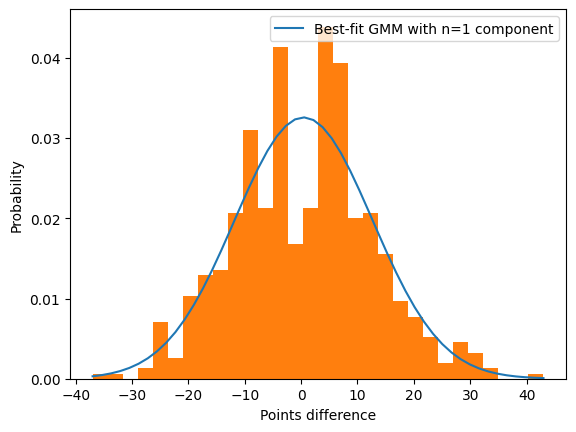

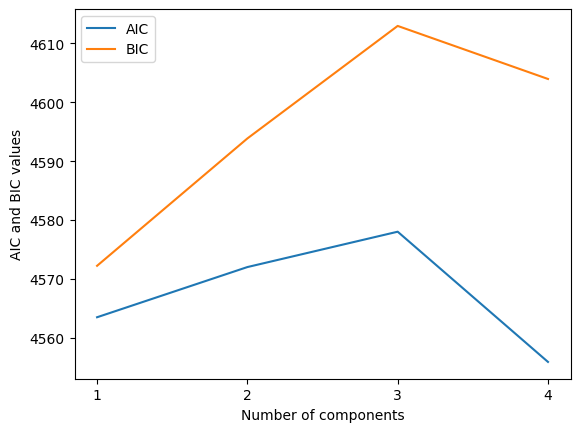

In [70]:
sample_plot(1200, 1500, 20, 2)

No. of samples = 581
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [0.43373494], Covariance = [[149.87727948]]
No. of samples = 581
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [0.43373494], Covariance = [[149.87727948]]
No. of samples = 581
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [0.43373494], Covariance = [[149.87727948]]
No. of samples = 581
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [0.43373494], Covariance = [[149.87727948]]


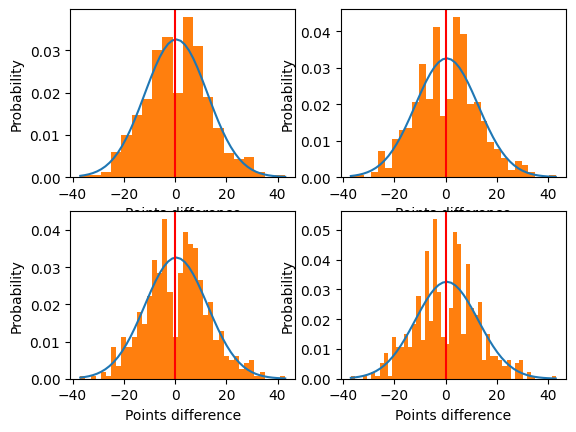

In [ ]:
plot_diffbins(1200, 1500, 20, 2)

No. of samples = 653
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [-0.08882083], Covariance = [[147.62151462]]


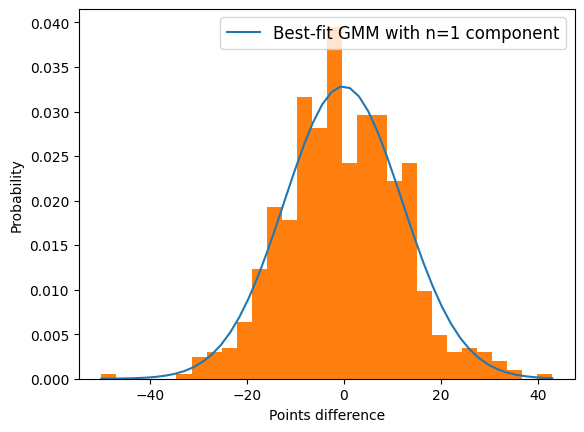

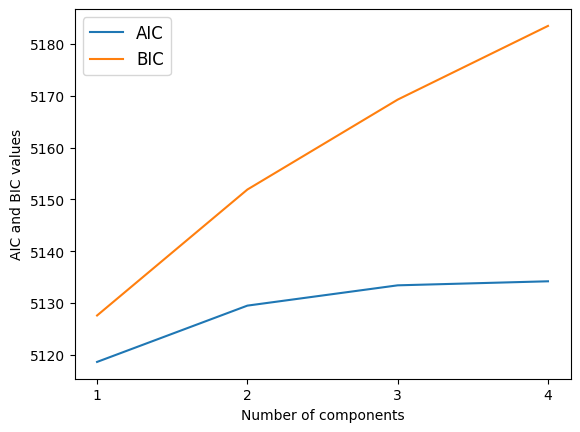

In [89]:
sample_plot(1500, 1800, 20, 2)

No. of samples = 653
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [-0.08882083], Covariance = [[147.62151462]]
No. of samples = 653
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [-0.08882083], Covariance = [[147.62151462]]
No. of samples = 653
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [-0.08882083], Covariance = [[147.62151462]]
No. of samples = 653
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [-0.08882083], Covariance = [[147.62151462]]


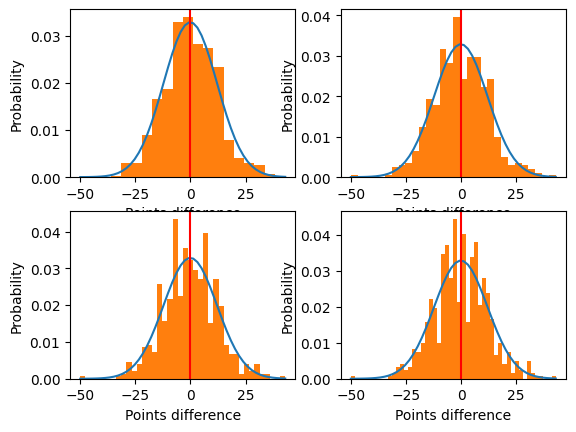

In [ ]:
plot_diffbins(1500, 1800, 20, 2)

No. of samples = 1362
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [0.23715125], Covariance = [[146.66696146]]


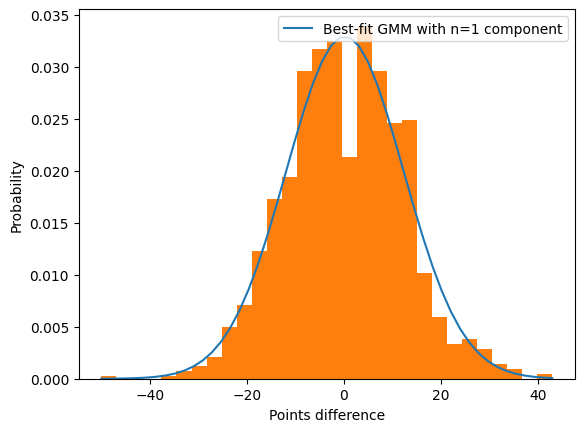

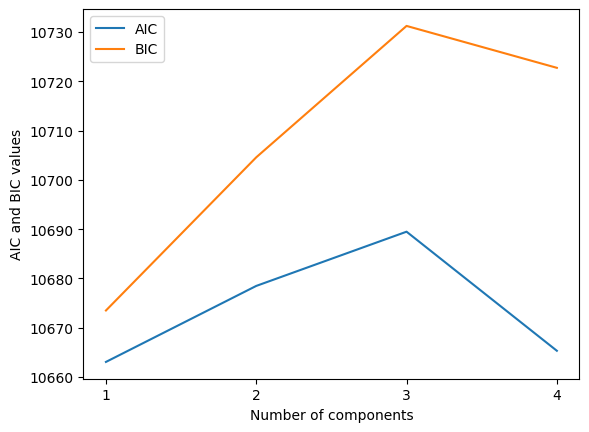

In [72]:
sample_plot(1000, 1900, 20, 2)

No. of samples = 1362
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [0.23715125], Covariance = [[146.66696146]]
No. of samples = 1362
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [0.23715125], Covariance = [[146.66696146]]
No. of samples = 1362
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [0.23715125], Covariance = [[146.66696146]]
No. of samples = 1362
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [0.23715125], Covariance = [[146.66696146]]


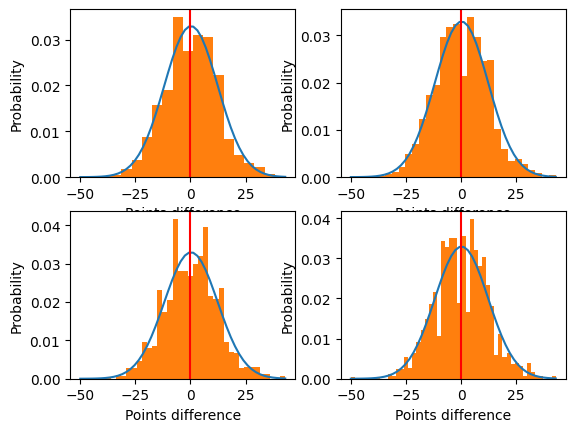

In [ ]:
plot_diffbins(1000, 1900, 20, 2)

No. of samples = 582
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [0.45360825], Covariance = [[149.84922338]]


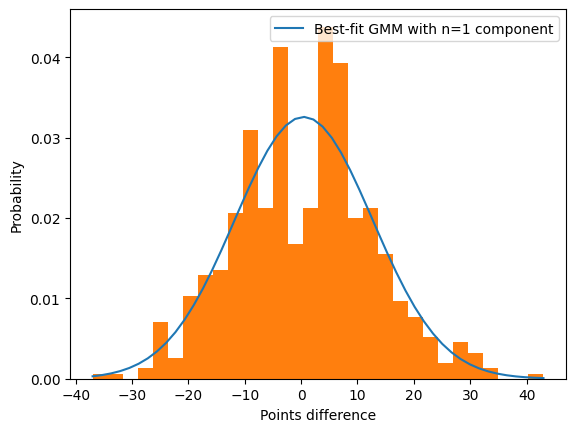

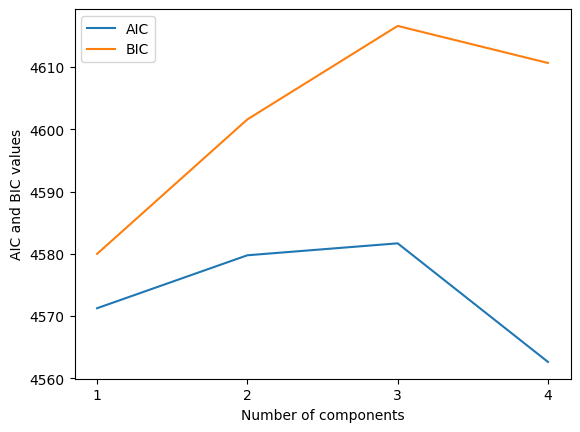

In [73]:
sample_plot(1000, 1500, 20, 2)

No. of samples = 582
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [0.45360825], Covariance = [[149.84922338]]
No. of samples = 582
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [0.45360825], Covariance = [[149.84922338]]
No. of samples = 582
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [0.45360825], Covariance = [[149.84922338]]
No. of samples = 582
Best number of components based on AIC: 4
Best number of components based on BIC: 1
Mean = [0.45360825], Covariance = [[149.84922338]]


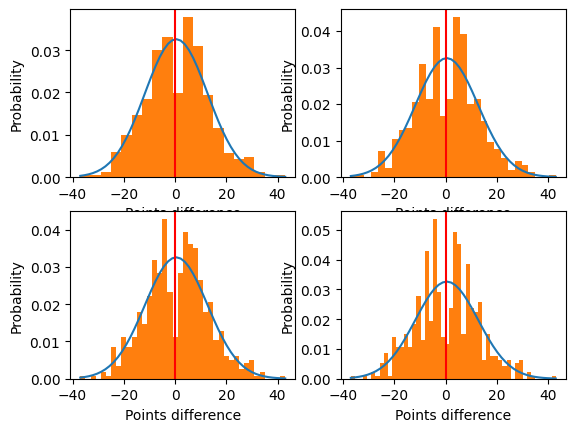

In [ ]:
plot_diffbins(1000, 1500, 20, 2)

### Misc.

No. of samples = 1461
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.98699521], Covariance = [[136.54124187]]
No. of samples = 1461
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.98699521], Covariance = [[136.54124187]]
No. of samples = 1461
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.98699521], Covariance = [[136.54124187]]
No. of samples = 1461
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.98699521], Covariance = [[136.54124187]]


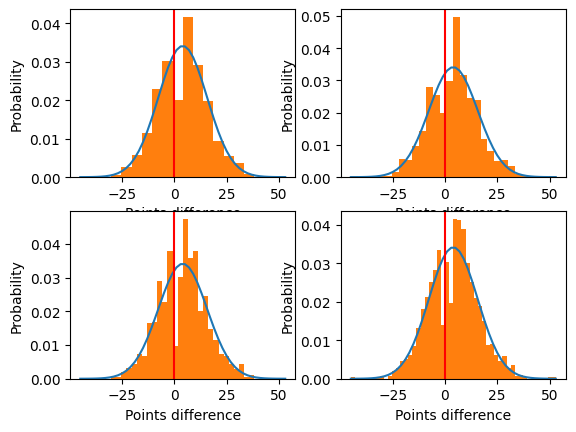

In [ ]:
plt.figure()

plt.subplot(2, 2, 1)
plot(1200, 1500, 100, 10, 20)

plt.subplot(2, 2, 2)
plot(1200, 1500, 100, 10, 30)

plt.subplot(2, 2, 3)
plot(1200, 1500, 100, 10, 40)

plt.subplot(2, 2, 4)
plot(1200, 1500, 100, 10, 50)

plt.show()

No. of samples = 1461
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [-3.98699521], Covariance = [[136.54124187]]
No. of samples = 1461
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [-3.98699521], Covariance = [[136.54124187]]
No. of samples = 1461
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [-3.98699521], Covariance = [[136.54124187]]
No. of samples = 1461
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [-3.98699521], Covariance = [[136.54124187]]


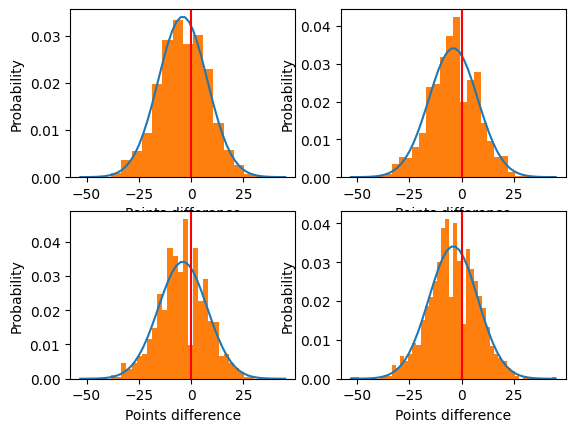

In [ ]:
plt.figure()

plt.subplot(2, 2, 1)
plot(1200, 1500, -100, 10, 20)

plt.subplot(2, 2, 2)
plot(1200, 1500, -100, 10, 30)

plt.subplot(2, 2, 3)
plot(1200, 1500, -100, 10, 40)

plt.subplot(2, 2, 4)
plot(1200, 1500, -100, 10, 50)

plt.show()

No. of samples = 1463
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.66985646], Covariance = [[164.50823112]]
No. of samples = 1463
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.66985646], Covariance = [[164.50823112]]
No. of samples = 1463
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.66985646], Covariance = [[164.50823112]]
No. of samples = 1463
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.66985646], Covariance = [[164.50823112]]


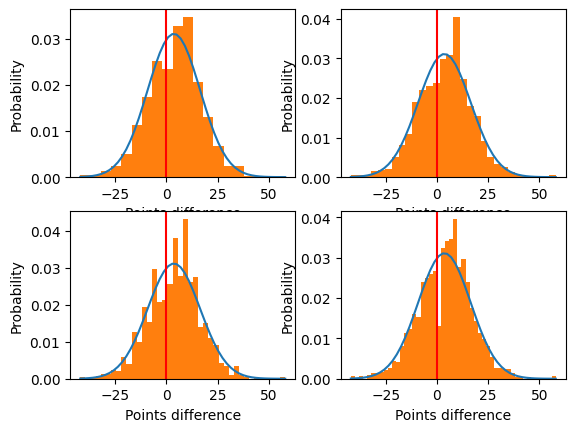

In [ ]:
plt.figure()

plt.subplot(2, 2, 1)
plot(1500, 1800, 100, 10, 20)

plt.subplot(2, 2, 2)
plot(1500, 1800, 100, 10, 30)

plt.subplot(2, 2, 3)
plot(1500, 1800, 100, 10, 40)

plt.subplot(2, 2, 4)
plot(1500, 1800, 100, 10, 50)

plt.show()

No. of samples = 126314
Best number of components based on AIC: 4
Best number of components based on BIC: 4
Mean = [6.7220662], Covariance = [[23.09071721]]
No. of samples = 126314
Best number of components based on AIC: 4
Best number of components based on BIC: 4
Mean = [6.7220662], Covariance = [[23.09071721]]
No. of samples = 126314
Best number of components based on AIC: 4
Best number of components based on BIC: 4
Mean = [6.7220662], Covariance = [[23.09071721]]
No. of samples = 126314
Best number of components based on AIC: 4
Best number of components based on BIC: 4
Mean = [6.7220662], Covariance = [[23.09071721]]


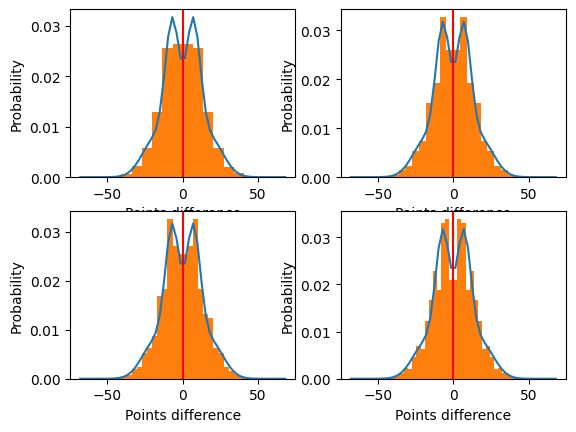

In [ ]:
plt.figure()

plt.subplot(2, 2, 1)
plot(900, 1900, 100, 1000000, 20)

plt.subplot(2, 2, 2)
plot(900, 1900, 100, 1000000, 30)

plt.subplot(2, 2, 3)
plot(900, 1900, 100, 1000000, 40)

plt.subplot(2, 2, 4)
plot(900, 1900, 100, 1000000, 50)

plt.show()

No. of samples = 10443
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.6151489], Covariance = [[152.46502862]]
No. of samples = 10443
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.6151489], Covariance = [[152.46502862]]
No. of samples = 10443
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.6151489], Covariance = [[152.46502862]]
No. of samples = 10443
Best number of components based on AIC: 1
Best number of components based on BIC: 1
Mean = [3.6151489], Covariance = [[152.46502862]]


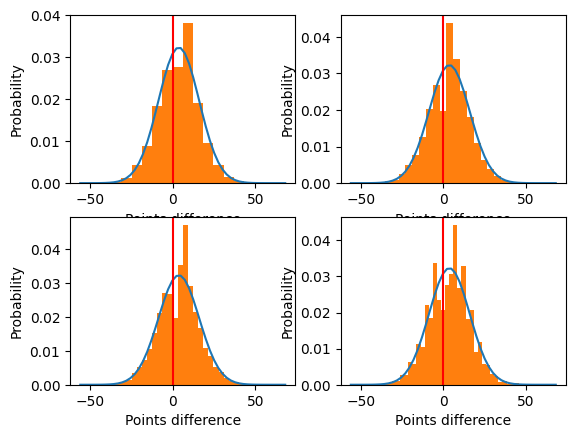

In [ ]:
plt.figure()

plt.subplot(2, 2, 1)
plot(900, 1900, 100, 20, 20)

plt.subplot(2, 2, 2)
plot(900, 1900, 100, 20, 30)

plt.subplot(2, 2, 3)
plot(900, 1900, 100, 20, 40)

plt.subplot(2, 2, 4)
plot(900, 1900, 100, 20, 50)

plt.show()

No. of samples = 5595
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [7.15460232], Covariance = [[150.41953076]]
No. of samples = 5595
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [7.15460232], Covariance = [[150.41953076]]
No. of samples = 5595
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [7.15460232], Covariance = [[150.41953076]]
No. of samples = 5595
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [7.15460232], Covariance = [[150.41953076]]


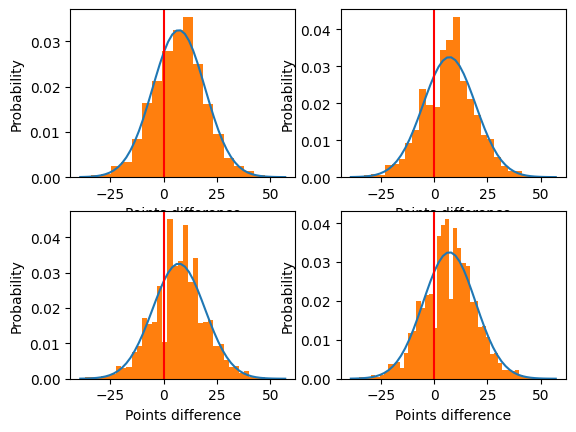

In [ ]:
plt.figure()

plt.subplot(2, 2, 1)
plot(900, 1900, 200, 20, 20)

plt.subplot(2, 2, 2)
plot(900, 1900, 200, 20, 30)

plt.subplot(2, 2, 3)
plot(900, 1900, 200, 20, 40)

plt.subplot(2, 2, 4)
plot(900, 1900, 200, 20, 50)

plt.show()

No. of samples = 1903
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [10.35522859], Covariance = [[148.7965672]]
No. of samples = 1903
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [10.35522859], Covariance = [[148.7965672]]
No. of samples = 1903
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [10.35522859], Covariance = [[148.7965672]]
No. of samples = 1903
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [10.35522859], Covariance = [[148.7965672]]


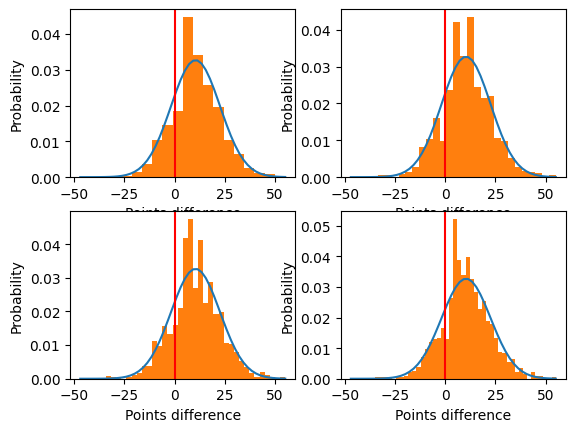

In [ ]:
plt.figure()

plt.subplot(2, 2, 1)
plot(900, 1900, 300, 20, 20)

plt.subplot(2, 2, 2)
plot(900, 1900, 300, 20, 30)

plt.subplot(2, 2, 3)
plot(900, 1900, 300, 20, 40)

plt.subplot(2, 2, 4)
plot(900, 1900, 300, 20, 50)

plt.show()

No. of samples = 380
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [13.18684211], Covariance = [[114.74140682]]
No. of samples = 380
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [13.18684211], Covariance = [[114.74140682]]
No. of samples = 380
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [13.18684211], Covariance = [[114.74140682]]
No. of samples = 380
Best number of components based on AIC: 3
Best number of components based on BIC: 1
Mean = [13.18684211], Covariance = [[114.74140682]]


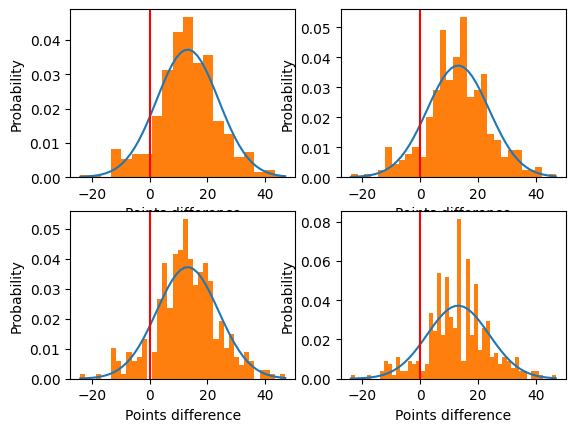

In [ ]:
plt.figure()

plt.subplot(2, 2, 1)
plot(900, 1900, 400, 20, 20)

plt.subplot(2, 2, 2)
plot(900, 1900, 400, 20, 30)

plt.subplot(2, 2, 3)
plot(900, 1900, 400, 20, 40)

plt.subplot(2, 2, 4)
plot(900, 1900, 400, 20, 50)

plt.show()

No. of samples = 6319
Best number of components based on AIC: 4
Best number of components based on BIC: 4
Mean = [-6.09515534], Covariance = [[23.05272375]]
No. of samples = 6319
Best number of components based on AIC: 4
Best number of components based on BIC: 4
Mean = [-6.09515534], Covariance = [[23.05272375]]
No. of samples = 6319
Best number of components based on AIC: 4
Best number of components based on BIC: 4
Mean = [-6.09515534], Covariance = [[23.05272375]]
No. of samples = 6319
Best number of components based on AIC: 4
Best number of components based on BIC: 4
Mean = [-6.09515534], Covariance = [[23.05272375]]


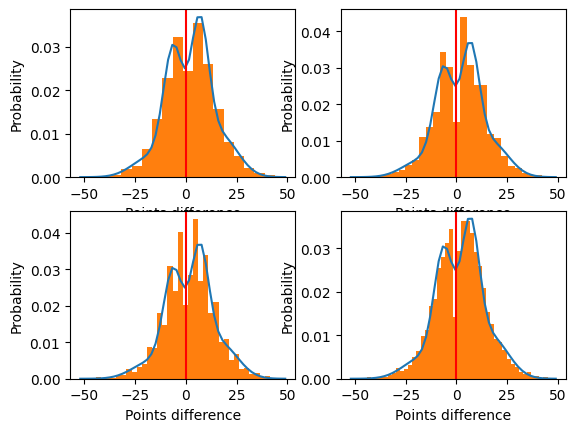

In [ ]:
plt.figure()

plt.subplot(2, 2, 1)
plot(900, 1900, 50, 10, 20)

plt.subplot(2, 2, 2)
plot(900, 1900, 50, 10, 30)

plt.subplot(2, 2, 3)
plot(900, 1900, 50, 10, 40)

plt.subplot(2, 2, 4)
plot(900, 1900, 50, 10, 50)

plt.show()

In [ ]:
def plot_equal_ELO(E_beg, E_end, E_diff, eps, b):

  samples = np.array([])
  for e1, e2, e_diff, p in zip(E1, E2, E1 - E2, P):
    if e1 != e2:
      continue

    if abs(e_diff - E_diff) <= eps:
      samples = np.append(samples, p)

  print(f'No. of samples = {len(samples)}')

  plt.hist(samples, density=True, bins=b)
  plt.xlabel('Points difference')
  plt.ylabel('Probability')
  plt.axvline(x = 0, color = 'r', label = 'Zero')